# Imports

In [ ]:
!pip install niapy --pre
# !pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 4.7 MB/s eta 0:00:00


In [ ]:
#imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay,RocCurveDisplay
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
# from niapy.algorithms.basic import ParticleSwarmOptimization
from niapy.problems import Problem
from niapy.task import Task
sc = StandardScaler()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utils

In [ ]:
def evaluate_fn(Y_test,model_pred):
    # cm = confusion_matrix(Y_test.argmax(), model_pred.argmax())
    cm = confusion_matrix(Y_test.astype(int).tolist(), model_pred)

    True_Positives = cm[0][0]
    False_Positives = cm[0][1]

    True_Negetives = cm[1][1]
    False_Negetives = cm[1][0]

    # return True_Positives,False_Positives,False_Negetives,True_Negetives

    precision =  True_Positives / (True_Positives + False_Positives)
    recall = True_Positives / (True_Positives + False_Negetives)
    f1_score = 2*(precision * recall) / (precision + recall)

    return precision,recall,f1_score

In [ ]:
# here X is features and y is labels
# k is the num_ of splits usally k = 3, k =5, or k = 10
def kfold(k, model, X, y):

  # prepare the cross-validation procedure
  cv = KFold(n_splits=k, random_state=1, shuffle=True)  # 10-fold cross-validation
  # evaluate model
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # report performance
  acc = mean(scores)

  return acc, scores.min(), scores.max()

def k_evaluate(k,model,x , y):
  acc_list = {}
  for i in range(2, k+1):
    acc,_,_ = kfold(i, model, x, y)
    acc_list.update( {i : acc} )
    print(f"for fold: {i}, accuracy is: {acc_list.get(i)}")
  # get max
  m_key = max(acc_list, key = acc_list.get)
  print("Best fit"             )
  print(f"{m_key} gives accuracy of {acc_list.get(m_key)}")
  return acc_list.get(m_key) # acc

# Data Preparation

In [ ]:
from scipy.io import arff
import pandas as pd

data1 = arff.loadarff(r"/content/drive/MyDrive/Work Space/Ovarian.arff")
data1 = pd.DataFrame(data1[0])
data1.head()

,MZ-7.86E-05,MZ2.18E-07,MZ9.60E-05,MZ0.000366014,MZ0.000810195,MZ0.001428564,MZ0.002221123,MZ0.003187869,MZ0.004328805,MZ0.005643929,...,MZ19974.404,MZ19977.042,MZ19979.68,MZ19982.319,MZ19984.957,MZ19987.596,MZ19990.235,MZ19992.874,MZ19995.513,Class
0,0.494626,0.263735,0.321841,0.220934,0.297622,0.316458,0.154763,0.223685,0.304346,0.241757,...,0.483622,0.449296,0.449296,0.449296,0.449296,0.449296,0.449296,0.449296,0.449296,b'Normal'
1,0.258063,0.406593,0.321841,0.069771,0.333335,0.354432,0.321431,0.144740,0.260869,0.142853,...,0.631765,0.619718,0.619718,0.619718,0.619718,0.619718,0.619718,0.619718,0.619718,b'Normal'
2,0.537636,0.032966,0.321841,0.209307,0.404762,0.113927,0.369049,0.223685,0.536231,0.131865,...,0.038462,0.035918,0.035918,0.035918,0.035918,0.035918,0.035918,0.035918,0.035918,b'Normal'
3,0.000000,0.395605,0.310347,0.197673,0.404762,0.455701,0.416666,0.210527,0.420292,0.274723,...,0.497864,0.486621,0.486621,0.486621,0.486621,0.486621,0.486621,0.486621,0.486621,b'Normal'
4,0.526884,0.395605,0.367817,0.383719,0.488099,0.392405,0.238094,0.500000,0.362316,0.274723,...,0.267096,0.251408,0.251408,0.251408,0.251408,0.251408,0.251408,0.251408,0.251408,b'Normal'


In [ ]:
len(data1)

253

we have 253 entries and 15155 columns in our dataset.

In [ ]:
# let's have a look at our columns
data1.columns

Index(['MZ-7.86E-05', 'MZ2.18E-07', 'MZ9.60E-05', 'MZ0.000366014',
       'MZ0.000810195', 'MZ0.001428564', 'MZ0.002221123', 'MZ0.003187869',
       'MZ0.004328805', 'MZ0.005643929',
       ...
       'MZ19974.404', 'MZ19977.042', 'MZ19979.68', 'MZ19982.319',
       'MZ19984.957', 'MZ19987.596', 'MZ19990.235', 'MZ19992.874',
       'MZ19995.513', 'Class'],
      dtype='object', length=15155)

Here column 'Class' is our predictive column or label column

In [ ]:
# Check for Null values in dataset
data1.isnull().sum()

MZ-7.86E-05      0
MZ2.18E-07       0
MZ9.60E-05       0
MZ0.000366014    0
MZ0.000810195    0
                ..
MZ19987.596      0
MZ19990.235      0
MZ19992.874      0
MZ19995.513      0
Class            0
Length: 15155, dtype: int64

There are non null values are here.

In [ ]:
# Check for unique classes in 'Class' column
data1.Class.unique()

array([b'Normal', b'Cancer'], dtype=object)

We have 2 classes one is Normal and another is Cancer.

In [ ]:
# class values are in byte string format but we need them in integer format
# Converting them into string first
y = data1.Class  # label
# len(y)
# y[0]
def cvt(str):
  return str.decode("utf-8")

for st in range(len(y)):
  y[st] = cvt(y[st])
# print(y)

<ipython-input-11-2a7445fa7bd8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[st] = cvt(y[st])


<Axes: xlabel='Class', ylabel='count'>

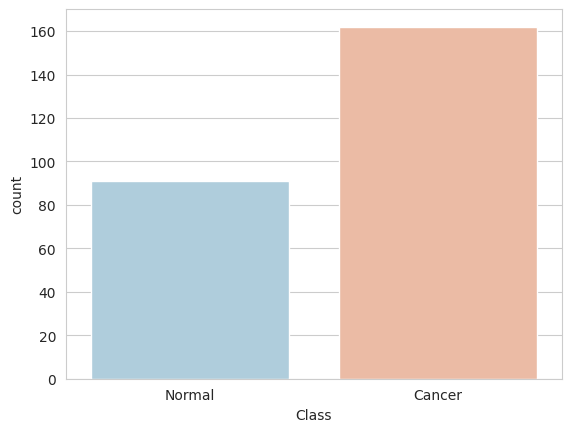

In [ ]:
# See the number of entries for each class
sns.set_style('whitegrid')
sns.countplot(x = 'Class', data= data1,palette = 'RdBu_r')

In [ ]:
# Then convert categorical class values into integer
y.replace({"Normal": 0, "Cancer": 1}, inplace= True)

As we can we have around 90 samples belongs to "Normal" class and around 165 belongs to "Cancer" class.

<ipython-input-14-2580fabbf035>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data1["MZ-7.86E-05"], bins=10)


<Axes: xlabel='MZ-7.86E-05', ylabel='Density'>

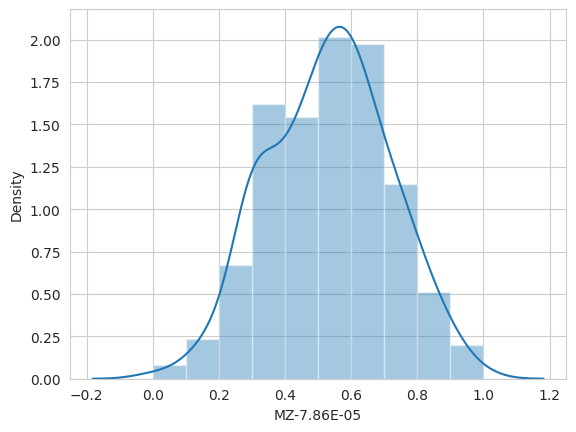

In [ ]:
# check the distribution of our output columns i.e "Class"
sns.distplot(data1["MZ-7.86E-05"], bins=10)

As almost all columns are gene expression values it doesnot make sence to draw any graphs between them but, we can always fraw the correlation matrix to see if they are corelated or not.

In [ ]:
y = y.astype(float)
x = data1.drop(['Class'], axis=1)

In [ ]:
col_dict = dict(enumerate((x.columns.to_numpy()).flatten(), 0))

# fetching column list
cols = (data1.columns).to_list()
len(cols)


15155

# Using sklearn GA

In [ ]:
!pip install sklearn-genetic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00


In [ ]:
from genetic_selection import GeneticSelectionCV

In [ ]:
estimators = DecisionTreeClassifier()
models = GeneticSelectionCV(
    estimators, cv=5, verbose=0,
    scoring="accuracy", max_features=100,
    n_population=100, crossover_proba=0.5,
    mutation_proba=0.2, n_generations=50,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3, n_gen_no_change=10,
    caching=True, n_jobs=-1)
models = models.fit(x, y)
print('Feature Selection:', x.columns[models.support_])

Feature Selection: Index(['MZ62.489616', 'MZ130.49326', 'MZ190.78426', 'MZ220.75125',
       'MZ245.8296', 'MZ264.61195', 'MZ332.21289', 'MZ435.85411',
       'MZ489.63357', 'MZ515.99887', 'MZ610.71997', 'MZ1191.0646',
       'MZ1352.0515', 'MZ1396.3322', 'MZ1612.659', 'MZ1699.2387',
       'MZ1830.1574', 'MZ2164.3565', 'MZ2171.3088', 'MZ2260.0402',
       'MZ2300.1462', 'MZ2885.6182', 'MZ3207.9766', 'MZ3741.1856',
       'MZ3833.0743', 'MZ4494.9871', 'MZ4701.276', 'MZ5347.9108',
       'MZ5438.3769', 'MZ5725.621', 'MZ6021.7052', 'MZ6674.332', 'MZ7045.314',
       'MZ7476.2755', 'MZ7790.9958', 'MZ7878.5571', 'MZ7890.1584',
       'MZ8030.0396', 'MZ8272.6953', 'MZ8448.4773', 'MZ9351.4967',
       'MZ10408.616', 'MZ10798.765', 'MZ11021.011', 'MZ11344.705',
       'MZ11582.513', 'MZ11946.91', 'MZ12310.737', 'MZ12675.819',
       'MZ13510.789', 'MZ13794.299', 'MZ14098.478', 'MZ14527.201',
       'MZ15299.843', 'MZ15475.807', 'MZ16019.186', 'MZ16315.841',
       'MZ16318.225', 'MZ17470.42',

In [ ]:
new_fea =  x.columns[models.support_] # new features
print(len(new_fea))

62


In [ ]:
# Regenerate data from new features
new_x = x[new_fea]
# split the data into train and validation set
x_train, x_test, y_train, y_test = train_test_split(new_x, y, test_size=0.10, random_state=101)
# Sacle the data
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

<Axes: >

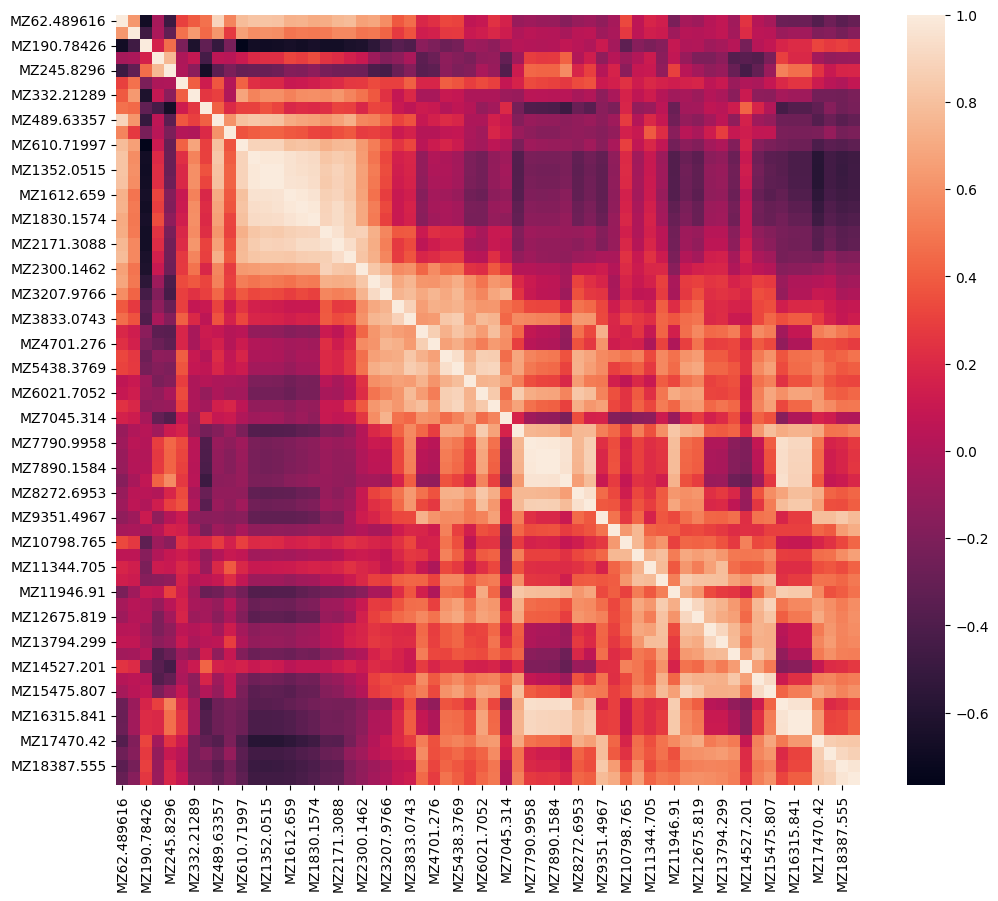

In [ ]:
# plot the correlation matrix for new dataset
cor = data1[new_fea].corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor)

## Classification

### SVC

In [ ]:
model = SVC()
model.fit(x_train, y_train)
model_pred = model.predict(x_test)
# Confusion matrix
cm = confusion_matrix(y_test,model_pred)
print(cm)
# classification report
print(classification_report(y_test,model_pred))

[[ 7  0]
 [ 0 19]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         7
         1.0       1.00      1.00      1.00        19

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



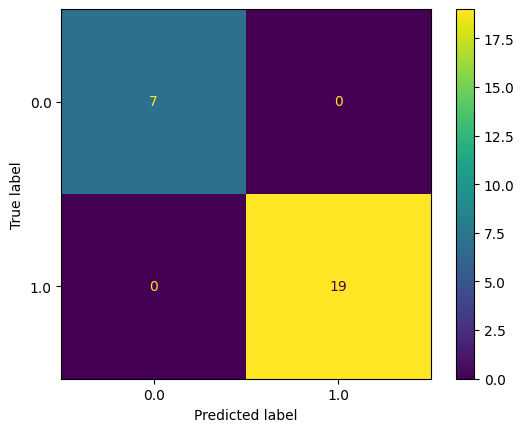

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

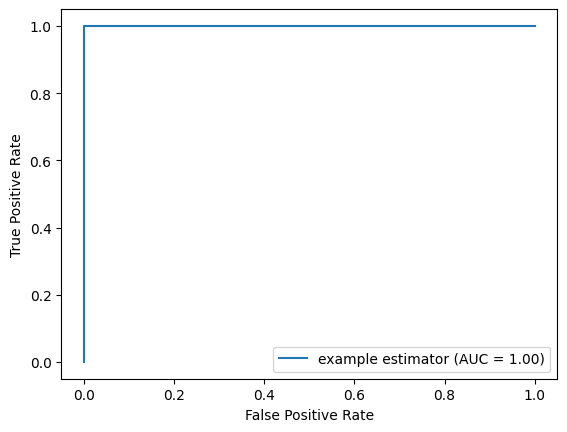

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = metrics.roc_curve(y_test, model_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

In [ ]:
acc = k_evaluate(10, model, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.9921259842519685
for fold: 3, accuracy is: 0.996078431372549
for fold: 4, accuracy is: 0.992125496031746
for fold: 5, accuracy is: 0.996078431372549
for fold: 6, accuracy is: 0.9961240310077519
for fold: 7, accuracy is: 0.9961389961389961
for fold: 8, accuracy is: 0.9921875
for fold: 9, accuracy is: 0.9961685823754789
for fold: 10, accuracy is: 0.9961538461538462
Best fit
9 gives accuracy of 0.9961685823754789


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', random_state=0)
dt.fit(x_train,y_train)
dt_pred = dt.predict(x_test)

# Confusion matrix
cm = confusion_matrix(y_test,dt_pred)
print(cm)
# classification report
print(classification_report(y_test,dt_pred))

[[ 7  0]
 [ 0 19]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         7
         1.0       1.00      1.00      1.00        19

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



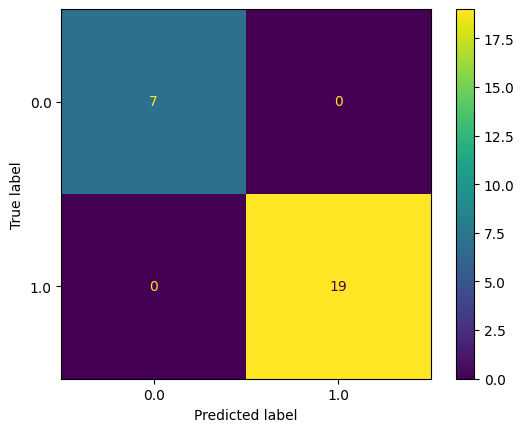

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()

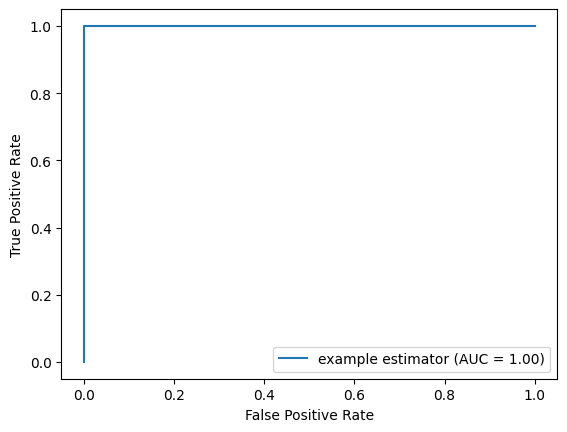

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = metrics.roc_curve(y_test, dt_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

In [ ]:
acc = k_evaluate(10, dt, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.9723784526934133
for fold: 3, accuracy is: 0.9645191409897292
for fold: 4, accuracy is: 0.9644717261904762
for fold: 5, accuracy is: 0.9607058823529412
for fold: 6, accuracy is: 0.9645625692137321
for fold: 7, accuracy is: 0.9725439725439725
for fold: 8, accuracy is: 0.9686239919354839
for fold: 9, accuracy is: 0.9683908045977011
for fold: 10, accuracy is: 0.9726153846153845
Best fit
10 gives accuracy of 0.9726153846153845


### LDA

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train,y_train)
lda_pred = lda.predict(x_test)

cm = confusion_matrix(y_test,lda_pred)
print(cm)
print('\n')
print(classification_report(y_test,lda_pred))

[[ 7  0]
 [ 0 19]]


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         7
         1.0       1.00      1.00      1.00        19

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



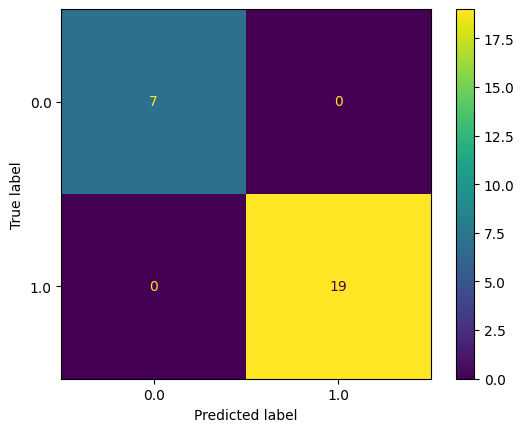

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda.classes_)
disp.plot()

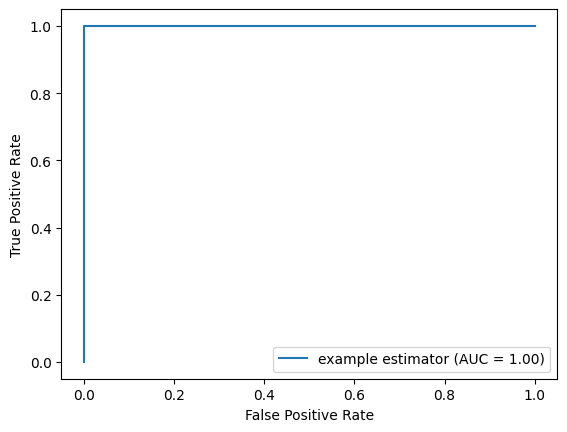

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = metrics.roc_curve(y_test, lda_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

In [ ]:
acc = k_evaluate(10, lda, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.9960629921259843
for fold: 3, accuracy is: 1.0
for fold: 4, accuracy is: 1.0
for fold: 5, accuracy is: 1.0
for fold: 6, accuracy is: 1.0
for fold: 7, accuracy is: 1.0
for fold: 8, accuracy is: 1.0
for fold: 9, accuracy is: 1.0
for fold: 10, accuracy is: 1.0
Best fit
3 gives accuracy of 1.0


# Gray Wolf Optimization

In [ ]:
os.chdir("/content/drive/MyDrive/Work Space")

In [ ]:
from FS.gwo import jfs

In [ ]:
y = data1['Class']
y = y.values
x = data1.drop(['Class'], axis= 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",x_test.shape)
print("y_test: ",y_test.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train shape:  (202, 15154)
y_train shape:  (202,)
x_text:  (51, 15154)
y_test:  (51,)


In [ ]:
# parameter
k    = 5     # k-value in KNN
N    = 10    # number of chromosomes
T    = 100   # maximum number of generations
CR   = 0.8
MR   = 0.01
fold = {'xt':x_train, 'yt':y_train, 'xv':x_test, 'yv':y_test}
x = x.to_numpy()
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'CR':CR, 'MR':MR}

In [ ]:
fmdl = jfs(x, y, opts)
sf   = fmdl['sf']

Iteration: 1
Best (GWO): 0.04377007817776706
Iteration: 2
Best (GWO): 0.04350612146666768
Iteration: 3
Best (GWO): 0.04327713901978897
Iteration: 4
Best (GWO): 0.04310622704935212
Iteration: 5
Best (GWO): 0.042869985792918175
Iteration: 6
Best (GWO): 0.042682576528037613
Iteration: 7
Best (GWO): 0.0425202431507115
Iteration: 8
Best (GWO): 0.04237374717605134
Iteration: 9
Best (GWO): 0.0422206522836137
Iteration: 10
Best (GWO): 0.042104511330729975
Iteration: 11
Best (GWO): 0.04199232972851274
Iteration: 12
Best (GWO): 0.04190522401384994
Iteration: 13
Best (GWO): 0.04178776327741072
Iteration: 14
Best (GWO): 0.04168548005185971
Iteration: 15
Best (GWO): 0.041571318774309224
Iteration: 16
Best (GWO): 0.04150269002942339
Iteration: 17
Best (GWO): 0.0413911683189839
Iteration: 18
Best (GWO): 0.04132055989876481
Iteration: 19
Best (GWO): 0.041239393210101755
Iteration: 20
Best (GWO): 0.04114040944343949
Iteration: 21
Best (GWO): 0.04107178069855365
Iteration: 22
Best (GWO): 0.0410137102221

In [ ]:
train = np.size(x_train, 0)
valid = np.size(x_test, 0)
x_train   = x_train[:, sf]
y_train   = y_train.reshape(train)
x_valid   = x_test[:, sf]
y_valid   = y_test.reshape(valid)

In [ ]:
f = fmdl['sf']
# featching features
features = []
for key, val in col_dict.items():
  if key in f:
    features.append(col_dict.get(key))
print ("Features length: ", len(features))
new_x = x[features]

Features length:  1625


Features length:  1625


<Axes: >

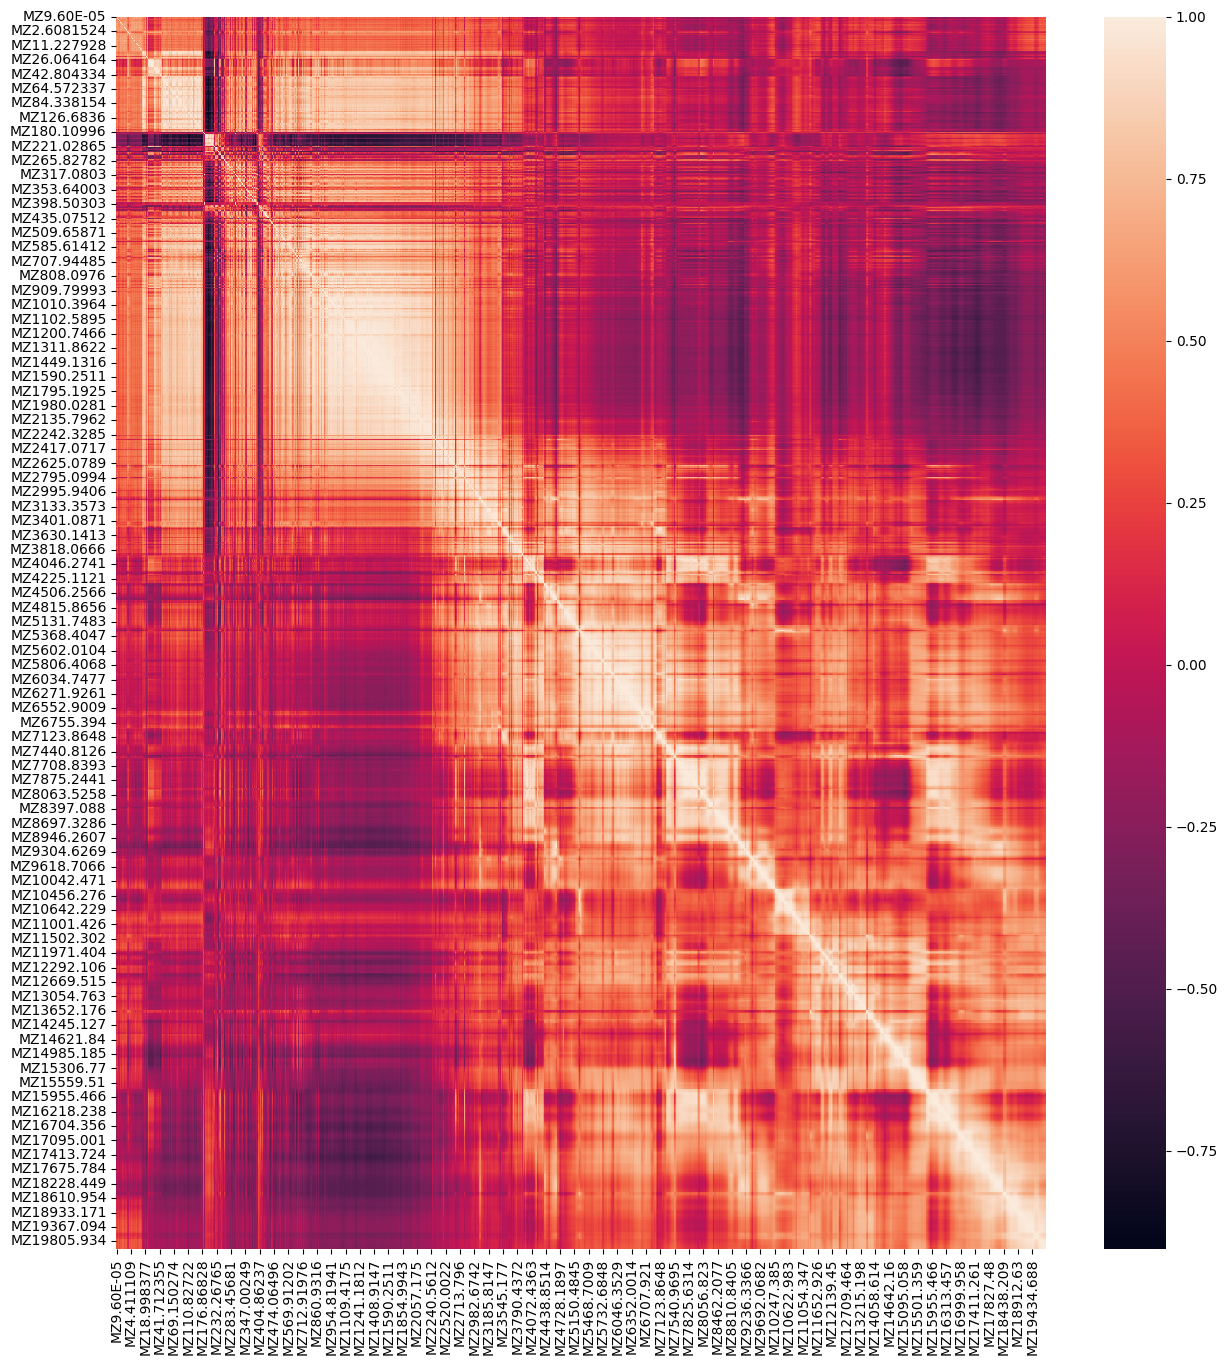

In [ ]:

# correlation matrix
cor = data1[features].corr()
plt.figure(figsize=(15,16))
sns.heatmap(cor)

## Classification Task

### SVC

In [ ]:
model = SVC()
model.fit(x_train,y_train)
model_pred = model.predict(x_valid)

# Confusion matrix
cm = confusion_matrix(y_valid,model_pred)
print(cm)
# classification report
print(classification_report(y_valid,model_pred))

[[18  0]
 [ 0 33]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        33

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



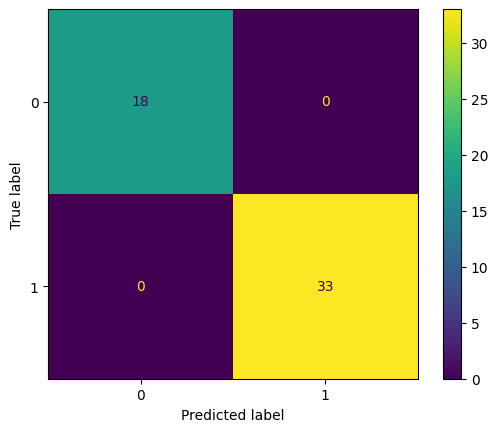

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

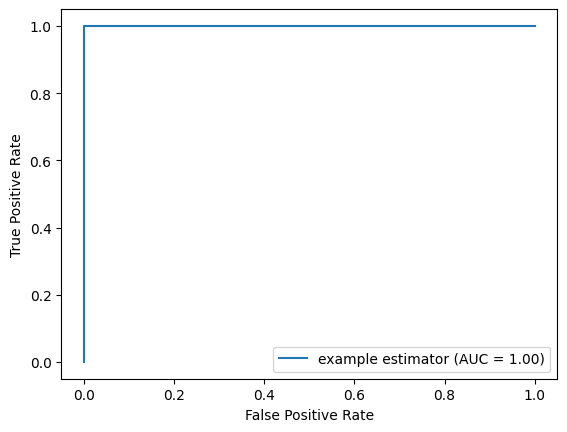

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, model_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

In [ ]:
# check with K-Fold cross validation
acc = k_evaluate(10, model, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.9684101987251593
for fold: 3, accuracy is: 0.9802521008403362
for fold: 4, accuracy is: 0.9802827380952381
for fold: 5, accuracy is: 0.9802352941176471
for fold: 6, accuracy is: 0.988187523071244
for fold: 7, accuracy is: 0.9842342342342343
for fold: 8, accuracy is: 0.9881552419354839
for fold: 9, accuracy is: 0.9882320744389711
for fold: 10, accuracy is: 0.9843076923076923
Best fit
9 gives accuracy of 0.9882320744389711


### LDA

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train,y_train)
lda_pred = lda.predict(x_valid)

# Confusion matrix
cm = confusion_matrix(y_valid,lda_pred)
print(cm)
# classification report
print(classification_report(y_valid,lda_pred))

[[18  0]
 [ 0 33]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        33

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



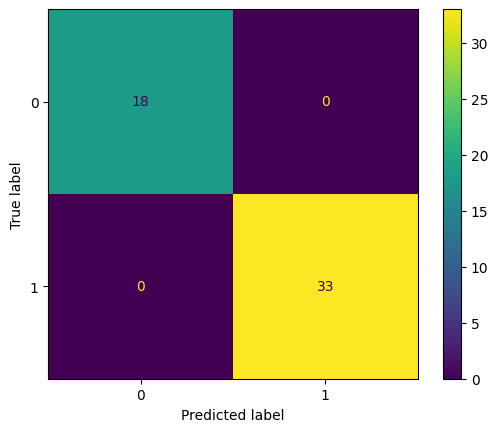

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda.classes_)
disp.plot()

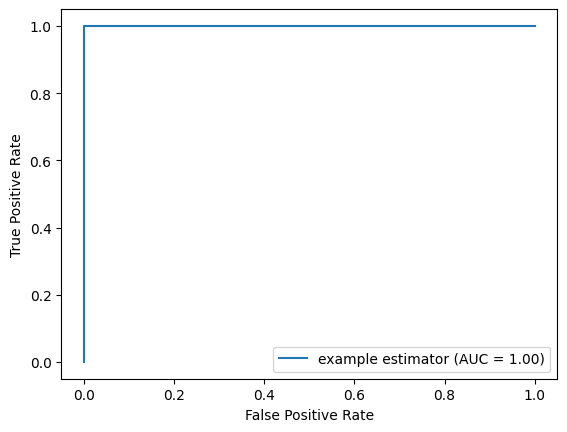

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, lda_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

In [ ]:
# check with K-Fold cross validation
acc = k_evaluate(10, lda, new_x, y)  # here k 10

for fold: 2, accuracy is: 1.0
for fold: 3, accuracy is: 1.0
for fold: 4, accuracy is: 1.0
for fold: 5, accuracy is: 1.0
for fold: 6, accuracy is: 1.0
for fold: 7, accuracy is: 1.0
for fold: 8, accuracy is: 1.0
for fold: 9, accuracy is: 1.0
for fold: 10, accuracy is: 1.0
Best fit
2 gives accuracy of 1.0


### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=10)
dt.fit(x_train, y_train)
dt_pred = dt.predict(x_valid)

# Confusion matrix
cm = confusion_matrix(y_valid,dt_pred)
print(cm)
# classification report
print(classification_report(y_valid,dt_pred))

[[17  1]
 [ 0 33]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.97      1.00      0.99        33

    accuracy                           0.98        51
   macro avg       0.99      0.97      0.98        51
weighted avg       0.98      0.98      0.98        51



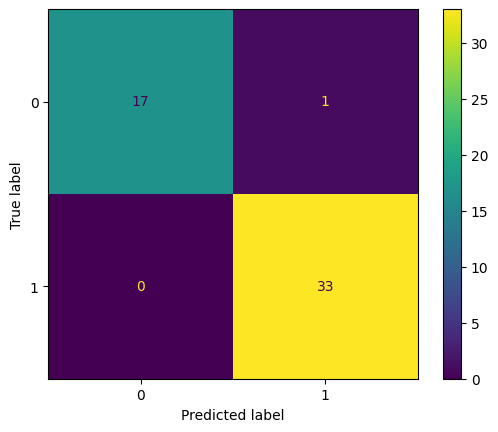

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()

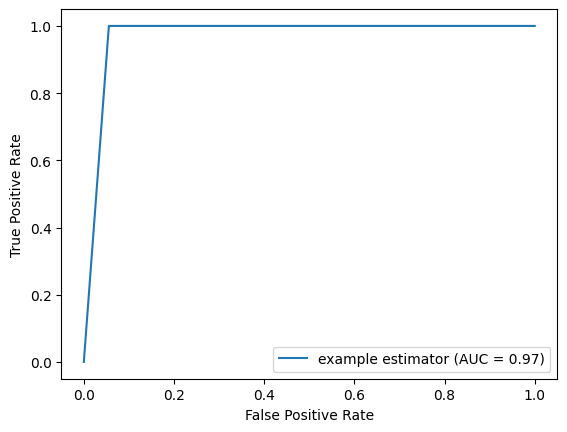

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, dt_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

In [ ]:
# check with K-Fold cross validation
acc = k_evaluate(10, dt, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.9565679290088739
for fold: 3, accuracy is: 0.9565359477124183
for fold: 4, accuracy is: 0.9446304563492063
for fold: 5, accuracy is: 0.9527843137254901
for fold: 6, accuracy is: 0.9447212993724623
for fold: 7, accuracy is: 0.9646074646074646
for fold: 8, accuracy is: 0.9567792338709677
for fold: 9, accuracy is: 0.9526546250684181
for fold: 10, accuracy is: 0.9486153846153847
Best fit
7 gives accuracy of 0.9646074646074646


# JAYA

In [ ]:
from FS.jaya import jfs

In [ ]:

# grab our features
y = data1['Class']
y = y.values
x = data1.drop(['Class'], axis= 1)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",x_test.shape)
print("y_test: ",y_test.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train shape:  (202, 15154)
y_train shape:  (202,)
x_text:  (51, 15154)
y_test:  (51,)


In [ ]:
x = x.to_numpy()

In [ ]:
# parameter
k = 5
N    = 10    # number of chromosomes
T    = 100   # maximum number of generations
fold = {'xt':x_train, 'yt':y_train, 'xv':x_test, 'yv':y_test}

opts = {'k':k, 'fold':fold, 'N':N, 'T':T}

In [ ]:
fmdl = jfs(x, y,opts)
sf   = fmdl['sf']

Generation: 1
Best (JA): 0.0437529209915456
Generation: 2
Best (JA): 0.04371992640265818
Generation: 3
Best (JA): 0.02435501401299603
Generation: 4
Best (JA): 0.02435501401299603
Generation: 5
Best (JA): 0.024289684726998932
Generation: 6
Best (JA): 0.024289684726998932
Generation: 7
Best (JA): 0.024289684726998932
Generation: 8
Best (JA): 0.024289684726998932
Generation: 9
Best (JA): 0.024289024835221183
Generation: 10
Best (JA): 0.024279126458554956
Generation: 11
Best (JA): 0.024279126458554956
Generation: 12
Best (JA): 0.024279126458554956
Generation: 13
Best (JA): 0.024279126458554956
Generation: 14
Best (JA): 0.024279126458554956
Generation: 15
Best (JA): 0.024279126458554956
Generation: 16
Best (JA): 0.024279126458554956
Generation: 17
Best (JA): 0.024279126458554956
Generation: 18
Best (JA): 0.02427516710788847
Generation: 19
Best (JA): 0.02427516710788847
Generation: 20
Best (JA): 0.02427516710788847
Generation: 21
Best (JA): 0.024267908298333234
Generation: 22
Best (JA): 0.02

In [ ]:
# Train_Val set with selected features
num_train = np.size(x_train, 0)
num_valid = np.size(x_test, 0)
x_train   = x_train[:, sf]
y_train   = y_train.reshape(num_train)
x_test   = x_test[:, sf]
y_test   = y_test.reshape(num_valid)

In [ ]:
f = fmdl['sf']
# featching features
features = []
for key, val in col_dict.items():
  if key in f:
    features.append(col_dict.get(key))

print("Feature Lenght: ", len(features))

Feature Lenght:  7234


In [ ]:
new_x = data1[features]
new_x.head()

,MZ2.18E-07,MZ0.001428564,MZ0.002221123,MZ0.004328805,MZ0.007133241,MZ0.008796743,MZ0.012646311,MZ0.022435711,MZ0.025318532,MZ0.042345469,...,MZ19948.033,MZ19950.67,MZ19953.306,MZ19958.58,MZ19961.217,MZ19966.491,MZ19969.128,MZ19979.68,MZ19984.957,MZ19987.596
0,0.263735,0.316458,0.154763,0.304346,0.277106,0.253731,0.270002,0.402174,0.311108,0.521008,...,0.467040,0.477515,0.473529,0.481342,0.473275,0.474182,0.460134,0.449296,0.449296,0.449296
1,0.406593,0.354432,0.321431,0.260869,0.518075,0.328356,0.270002,0.586957,0.288886,0.411763,...,0.629029,0.624555,0.644669,0.634964,0.625804,0.643634,0.644474,0.619718,0.619718,0.619718
2,0.032966,0.113927,0.369049,0.536231,0.469877,0.044775,0.330000,0.391305,0.233332,0.529411,...,0.088359,0.074231,0.062363,0.055594,0.059872,0.034907,0.029993,0.035918,0.035918,0.035918
3,0.395605,0.455701,0.416666,0.420292,0.542170,0.313431,0.249998,0.467389,0.177778,0.319330,...,0.483872,0.488221,0.483687,0.492320,0.482541,0.471274,0.487928,0.486621,0.486621,0.486621
4,0.395605,0.392405,0.238094,0.362316,0.289160,0.462688,0.450001,0.413043,0.222222,0.394957,...,0.217392,0.224125,0.228430,0.252375,0.244479,0.244360,0.238478,0.251408,0.251408,0.251408


### SVC

In [ ]:
model = SVC()
model.fit(x_train,y_train)
model_pred = model.predict(x_test)

# Confusion matrix
cm = confusion_matrix(y_test,model_pred)
print(cm)
# classification report
print(classification_report(y_test,model_pred))

[[18  0]
 [ 0 33]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        33

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



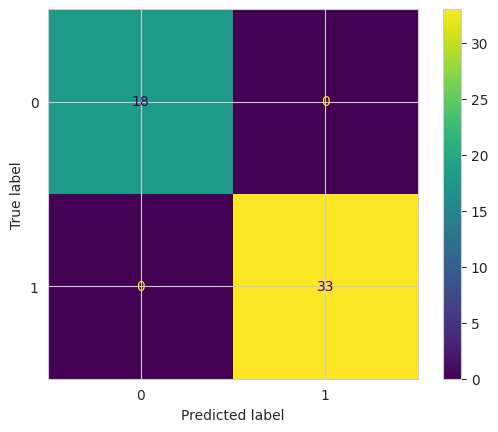

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

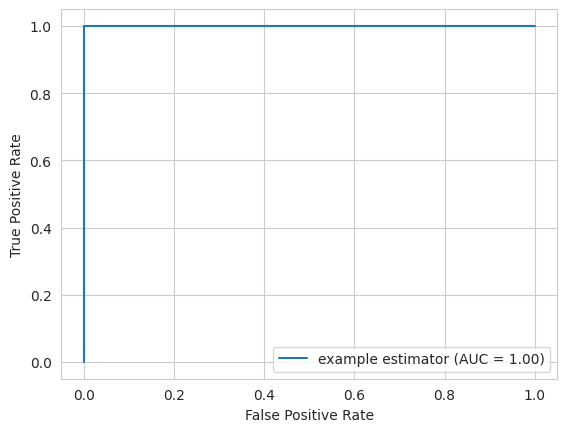

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = metrics.roc_curve(y_test, model_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

In [ ]:
# check with K-Fold cross validation
acc = k_evaluate(10, model, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.9684101987251593
for fold: 3, accuracy is: 0.9802521008403362
for fold: 4, accuracy is: 0.9802827380952381
for fold: 5, accuracy is: 0.9802352941176471
for fold: 6, accuracy is: 0.9842192691029901
for fold: 7, accuracy is: 0.9842342342342343
for fold: 8, accuracy is: 0.9842489919354839
for fold: 9, accuracy is: 0.984263820470717
for fold: 10, accuracy is: 0.9803076923076922
Best fit
9 gives accuracy of 0.984263820470717


### LDA

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train,y_train)
lda_pred = lda.predict(x_test)

# Confusion matrix
cm = confusion_matrix(y_test,lda_pred)
print(cm)
# classification report
print(classification_report(y_test,lda_pred))

[[18  0]
 [ 0 33]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        33

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



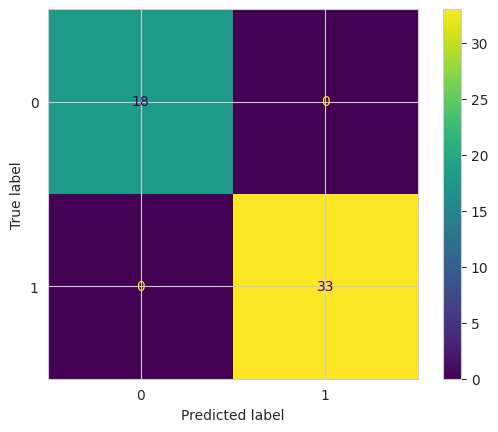

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda.classes_)
disp.plot()

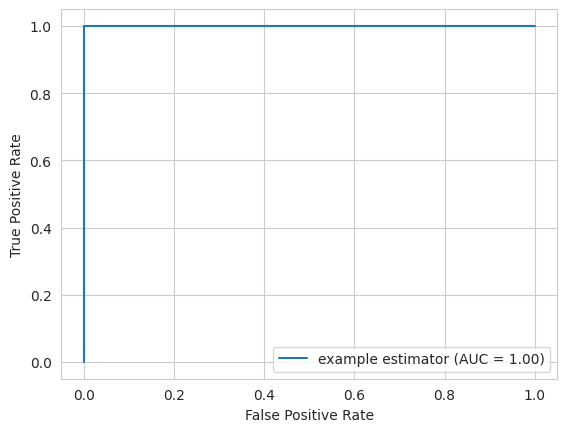

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = metrics.roc_curve(y_test, lda_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

In [ ]:
# check with K-Fold cross validation
acc = k_evaluate(10, lda, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.9920947381577303
for fold: 3, accuracy is: 0.996078431372549
for fold: 4, accuracy is: 1.0
for fold: 5, accuracy is: 1.0
for fold: 6, accuracy is: 1.0
for fold: 7, accuracy is: 1.0
for fold: 8, accuracy is: 1.0
for fold: 9, accuracy is: 1.0
for fold: 10, accuracy is: 1.0
Best fit
4 gives accuracy of 1.0


### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=10)
dt.fit(x_train, y_train)
dt_pred = dt.predict(x_test)

# Confusion matrix
cm = confusion_matrix(y_test,dt_pred)
print(cm)
# classification report
print(classification_report(y_test,dt_pred))

[[18  0]
 [ 0 33]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        33

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



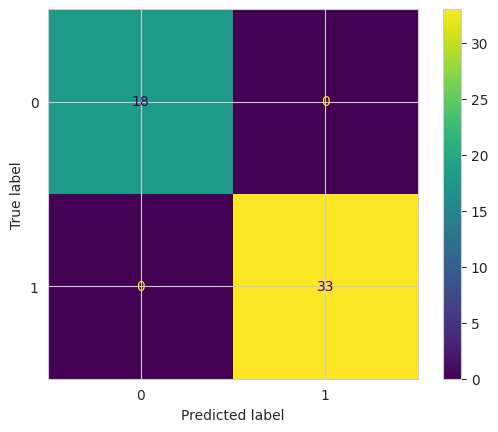

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()

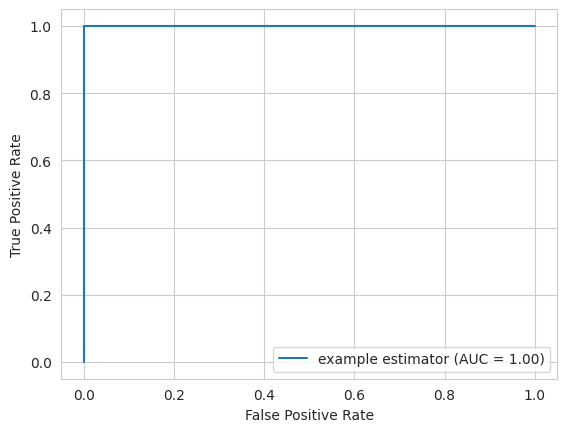

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = metrics.roc_curve(y_test, dt_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

In [ ]:
# check with K-Fold cross validation
acc = k_evaluate(10, dt, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.9762842144731909
for fold: 3, accuracy is: 0.9604575163398693
for fold: 4, accuracy is: 0.9644097222222223
for fold: 5, accuracy is: 0.9603137254901961
for fold: 6, accuracy is: 0.9644702842377262
for fold: 7, accuracy is: 0.9724367224367224
for fold: 8, accuracy is: 0.9684979838709677
for fold: 9, accuracy is: 0.972495894909688
for fold: 10, accuracy is: 0.9684615384615384
Best fit
2 gives accuracy of 0.9762842144731909


# Salp Swarm Algorithm

In [ ]:
from FS.ssa import jfs

In [ ]:
# grab our features
y = data1['Class']
y = y.values
x = data1.drop(['Class'], axis= 1)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",x_test.shape)
print("y_test: ",y_test.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train shape:  (202, 15154)
y_train shape:  (202,)
x_text:  (51, 15154)
y_test:  (51,)


In [ ]:
# parameter
k    = 5     # k value for KNN
N    = 10    # number of chromosomes
T    = 100   # maximum number of generations
fold = {'xt':x_train, 'yt':y_train, 'xv':x_test, 'yv':y_test}

opts = {'k':k, 'fold':fold, 'N':N, 'T':T}

In [ ]:
x = x.to_numpy()

In [ ]:
fmdl = jfs(x, y,opts)
sf   = fmdl['sf']

Iteration: 1
Best (SSA): 0.04377403752843355
Iteration: 2
Best (SSA): 0.04377403752843355
Iteration: 3
Best (SSA): 0.04377403752843355
Iteration: 4
Best (SSA): 0.04377403752843355
Iteration: 5
Best (SSA): 0.04377403752843355
Iteration: 6
Best (SSA): 0.04377403752843355
Iteration: 7
Best (SSA): 0.04375622045043434
Iteration: 8
Best (SSA): 0.04375556055865659
Iteration: 9
Best (SSA): 0.04375556055865659
Iteration: 10
Best (SSA): 0.04375556055865659
Iteration: 11
Best (SSA): 0.04375556055865659
Iteration: 12
Best (SSA): 0.024470495074102008
Iteration: 13
Best (SSA): 0.024470495074102008
Iteration: 14
Best (SSA): 0.024469835182324262
Iteration: 15
Best (SSA): 0.02443552080988134
Iteration: 16
Best (SSA): 0.02443552080988134
Iteration: 17
Best (SSA): 0.02443552080988134
Iteration: 18
Best (SSA): 0.02443552080988134
Iteration: 19
Best (SSA): 0.02443552080988134
Iteration: 20
Best (SSA): 0.02443552080988134
Iteration: 21
Best (SSA): 0.02443552080988134
Iteration: 22
Best (SSA): 0.024435520809

In [ ]:
# Train_Val set with selected features
num_train = np.size(x_train, 0)
num_valid = np.size(x_test, 0)
x_train   = x_train[:, sf]
y_train   = y_train.reshape(num_train)
x_test   = x_test[:, sf]
y_test   = y_test.reshape(num_valid)

In [ ]:
f = fmdl['sf']
# featching features
features = []
for key, val in col_dict.items():
  if key in f:
    features.append(col_dict.get(key))

print("Feature Lenght: ", len(features))

Feature Lenght:  7589


In [ ]:
new_x = data1[features]

## Classification

### SVC

In [ ]:
model = SVC()
model.fit(x_train,y_train)
model_pred = model.predict(x_test)

# Confusion matrix
cm = confusion_matrix(y_test,model_pred)
print(cm)
# classification report
print(classification_report(y_test,model_pred))

[[18  0]
 [ 0 33]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        33

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



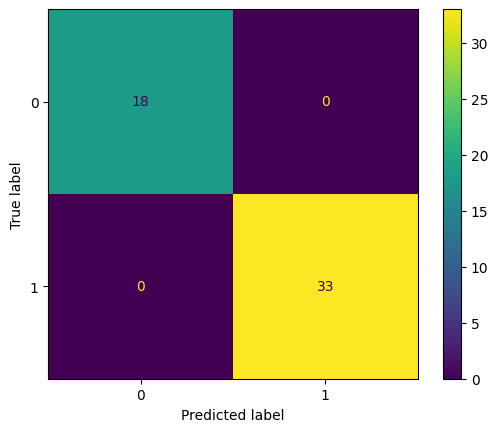

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

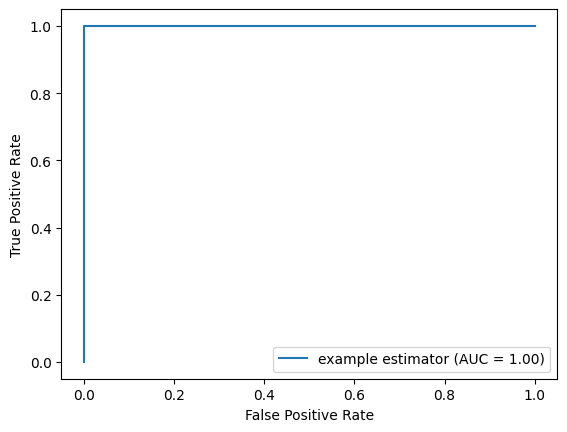

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = metrics.roc_curve(y_test, model_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

In [ ]:
# check with K-Fold cross validation
acc = k_evaluate(10, model, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.9723472065991751
for fold: 3, accuracy is: 0.9802521008403362
for fold: 4, accuracy is: 0.9802827380952381
for fold: 5, accuracy is: 0.9802352941176471
for fold: 6, accuracy is: 0.9842192691029901
for fold: 7, accuracy is: 0.9842342342342343
for fold: 8, accuracy is: 0.9842489919354839
for fold: 9, accuracy is: 0.984263820470717
for fold: 10, accuracy is: 0.9803076923076922
Best fit
9 gives accuracy of 0.984263820470717


### LDA

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train,y_train)
lda_pred = lda.predict(x_test)

# Confusion matrix
cm = confusion_matrix(y_test,lda_pred)
print(cm)
# classification report
print(classification_report(y_test,lda_pred))

[[18  0]
 [ 0 33]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        33

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



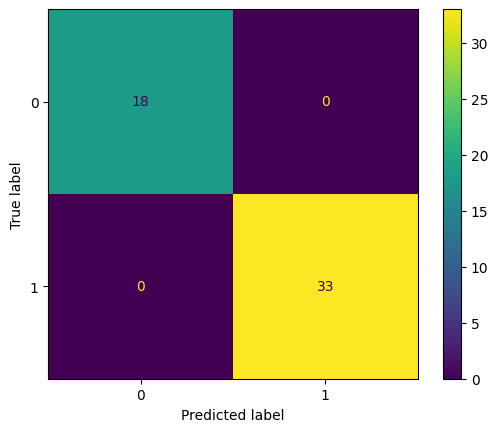

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda.classes_)
disp.plot()

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = metrics.roc_curve(y_test, lda_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

In [ ]:
# check with K-Fold cross validation
acc = k_evaluate(10, lda, new_x, y)  # here k 10

for fold: 2, accuracy is: 1.0
for fold: 3, accuracy is: 1.0
for fold: 4, accuracy is: 1.0
for fold: 5, accuracy is: 1.0
for fold: 6, accuracy is: 1.0
for fold: 7, accuracy is: 1.0
for fold: 8, accuracy is: 1.0
for fold: 9, accuracy is: 1.0
for fold: 10, accuracy is: 1.0
Best fit
2 gives accuracy of 1.0


### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=10)
dt.fit(x_train, y_train)
dt_pred = dt.predict(x_test)

# Confusion matrix
cm = confusion_matrix(y_test,dt_pred)
print(cm)
# classification report
print(classification_report(y_test,dt_pred))

[[18  0]
 [ 1 32]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.97      0.98        33

    accuracy                           0.98        51
   macro avg       0.97      0.98      0.98        51
weighted avg       0.98      0.98      0.98        51



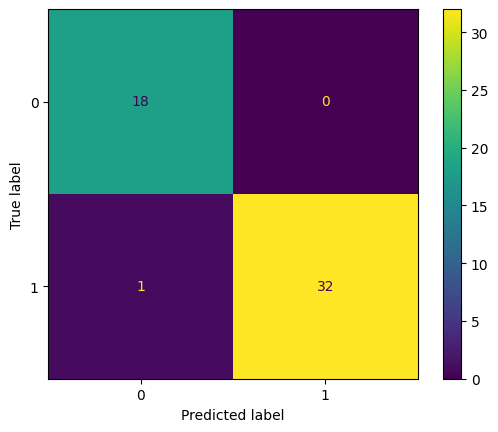

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()

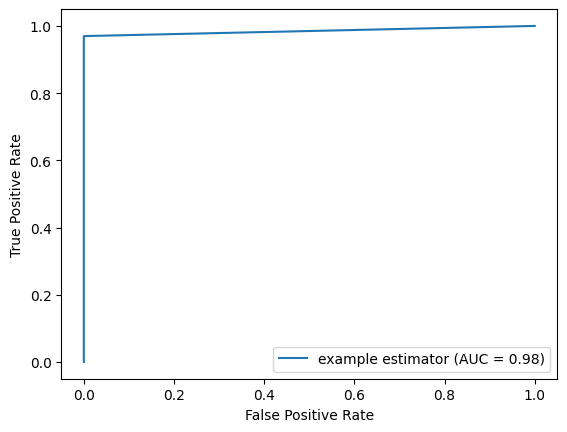

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = metrics.roc_curve(y_test, dt_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

In [ ]:
# check with K-Fold cross validation
acc = k_evaluate(10, dt, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.9446631671041119
for fold: 3, accuracy is: 0.9486928104575162
for fold: 4, accuracy is: 0.9643477182539684
for fold: 5, accuracy is: 0.9723921568627449
for fold: 6, accuracy is: 0.9723145071982282
for fold: 7, accuracy is: 0.9524882024882027
for fold: 8, accuracy is: 0.9683719758064516
for fold: 9, accuracy is: 0.9763273125342091
for fold: 10, accuracy is: 0.9721538461538461
Best fit
9 gives accuracy of 0.9763273125342091
